**Метрики линейных и прочих невременных моделей для задачи временного прогнозирования**

**Вступление**

Created on 13.10.2022

@author: Nata

На основе SVOD0 - сводной таблицы результатов расчета trnsys для точек России с выработкой результирующей и прогнозной
строим модели для предсказания результирующей выработки для уменьшения ошибки прогнозирования, получаемой с использованием trnsys

Библиотека lightgbm градиентный бустинг показала неплохие результаты для решения задач прогнозирования временных рядов.
Собираем метрики по ценовым зонам РФ.

В свойствах добавлен день недели. Это свойство для точки (62, 130) (Якутск) обладает интересными характеристиками: пробивает верхнюю
границу полосы допустимого профита по средам, а нижнюю по четвергам. Наименьшие потери по воскресеньям.
Проверить гипотезу об аналогичном поведении в других геоточках ценовыхзон.

Горизонт прогноза 48 часов


Расчет метрик производился на кросс-валидации (192 временных интервала на кроссвалидации для временных рядов)

In [1]:
import warnings
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.strategies import ParallelStrategy
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
#from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [2]:
from rffi_utils import generate_int_id, display_data,\
    show_correlation, create_features, get_boxplot

### Функции

In [3]:
def graph_month_hour(_data, _col):
        
    for city in list(data['city'].unique()):
        plt.subplot(121)
        for i in range(1,13):

            sns.distplot(_data[(data['city']==city)&\
                               (data['month']==i)][_col],\
                hist=False,label=str(i))
        plt.legend(title=city, loc='upper right',\
                   labels=['Jan', 'Feb', 'Mar', 'Apr','May',\
                           'Jun','Jul', 'Aug','Sep','Oct',"Nov",'Dec'])    
        plt.subplot(122)

        ax = sns.boxplot(x="hour", y=_col, data=_data[(data['city']==city)])
        plt.show()

In [4]:
def plot_corr(idpoint, module, col):
    
    #idpoint=2486
    #module = 'ceres_hevel395'
    #col = 'ghi'
    city = dict_city[idpoint]
    _data = data[(data['idpoint']==idpoint)&\
                (data[module]>0)
                ]
    g = sns.JointGrid(data=_data,\
                      x=_data[col],
                      y=_data[module],\
                      hue="month",# ratio=2, space=.05,
                      palette="Set1")
    g.plot(sns.scatterplot, sns.histplot, alpha=0.5, linewidth=.5)
    g.set_axis_labels(xlabel=col, ylabel=module)
    g.plot_marginals(sns.histplot, kde=True)
    plt.title(city)
    plt.show()

In [5]:
# Исходные данные
#data = pd.read_csv(r'D:\tmp\svod_1_6.csv')
# Получение данные из sse_power: D:\WorkE\rffi2022\sse_power_parameters.xlsx
#data = pd.read_csv(r'F:\svod.csv')
data = pd.read_csv(r'D:\WorkE\rffi2022\results\metrics_result_lgb.csv')

### Данные 
- 2486 - Мурманск (69, 33)
- 3702 - Астрахань (46, 47)
- 5221 - Иркутск (52, 103)
- 6087 - Казань (55, 48)
- 6128 - Москва (55,37)
- 6260 - Тюмень (57,65) 

In [18]:
dict_city = {2486:'Мурманск',3702:'Астрахань',5221:'Иркутск',\
            6087:'Казань', 6128:'Москва', 6260:'Тюмень'  }
dict_city2 = {'6933':'Мурманск','4647':'Астрахань','52103':'Иркутск',\
            '5548':'Казань', '5537':'Москва', '5765':'Тюмень'  }

In [32]:
data['city'] = data['lat'].astype('int').astype('str') +  data['lon'].astype('int').astype('str')
data['city'] = data['city'].replace(dict_city2)
data = data.drop('step', axis=1)

In [33]:
data.head(5)

lat   lon    module    model  losses0  losses     mae  mae_min  \
0  46.5  47.5  hevel320      lgb    0.152   0.314  18.023     3.90   
1  46.5  47.5  hevel320       lr    0.370   0.044   9.838     3.15   
2  46.5  47.5  hevel320  polynom    0.370   0.048   8.551     2.82   
3  46.5  47.5  hevel320       rf    0.370   0.041   7.508     2.43   
4  46.5  47.5  hevel320   xboost    0.370   0.042   8.002     2.85   

   losses0_max  losses_max  mae_max       city  
0        1.398       2.567    45.53  Астрахань  
1        2.875       1.184    50.98  Астрахань  
2        2.875       1.214    50.01  Астрахань  
3        2.875       0.965    40.24  Астрахань  
4        2.875       0.980    42.20  Астрахань

### Результаты сравнения расчетов на моделях машинного обучения

In [34]:
data.describe()

lat         lon    losses0     losses        mae    mae_min  \
count  52.000000   52.000000  52.000000  52.000000  52.000000  52.000000   
mean   54.115385   59.461538   0.303904   0.100212  11.292212   3.360000   
std     4.915577   23.665116   0.137559   0.120757   4.638376   1.584753   
min    46.500000   33.500000   0.108000   0.020000   6.156000   0.100000   
25%    52.500000   47.500000   0.179250   0.034750   8.628750   2.417500   
50%    55.500000   48.500000   0.328000   0.049000   9.836500   3.060000   
75%    55.500000   65.500000   0.380000   0.074750  11.415500   4.107500   
max    69.500000  103.500000   0.560000   0.526000  28.685000   8.510000   

       losses0_max  losses_max    mae_max  
count    52.000000   52.000000  52.000000  
mean      2.722635    0.881519  31.902885  
std       0.785656    0.788192  14.427379  
min       0.961000    0.144000  13.450000  
25%       2.150500    0.275250  20.292500  
50%       2.875000    0.458500  24.440000  
75%       3.389000    1.231250  45.365000  
max       3.771000    2.959000  61.220000

C:\Users\talic\Skillfactory\ВременныеРяды\rffi_utils.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[features].corr()


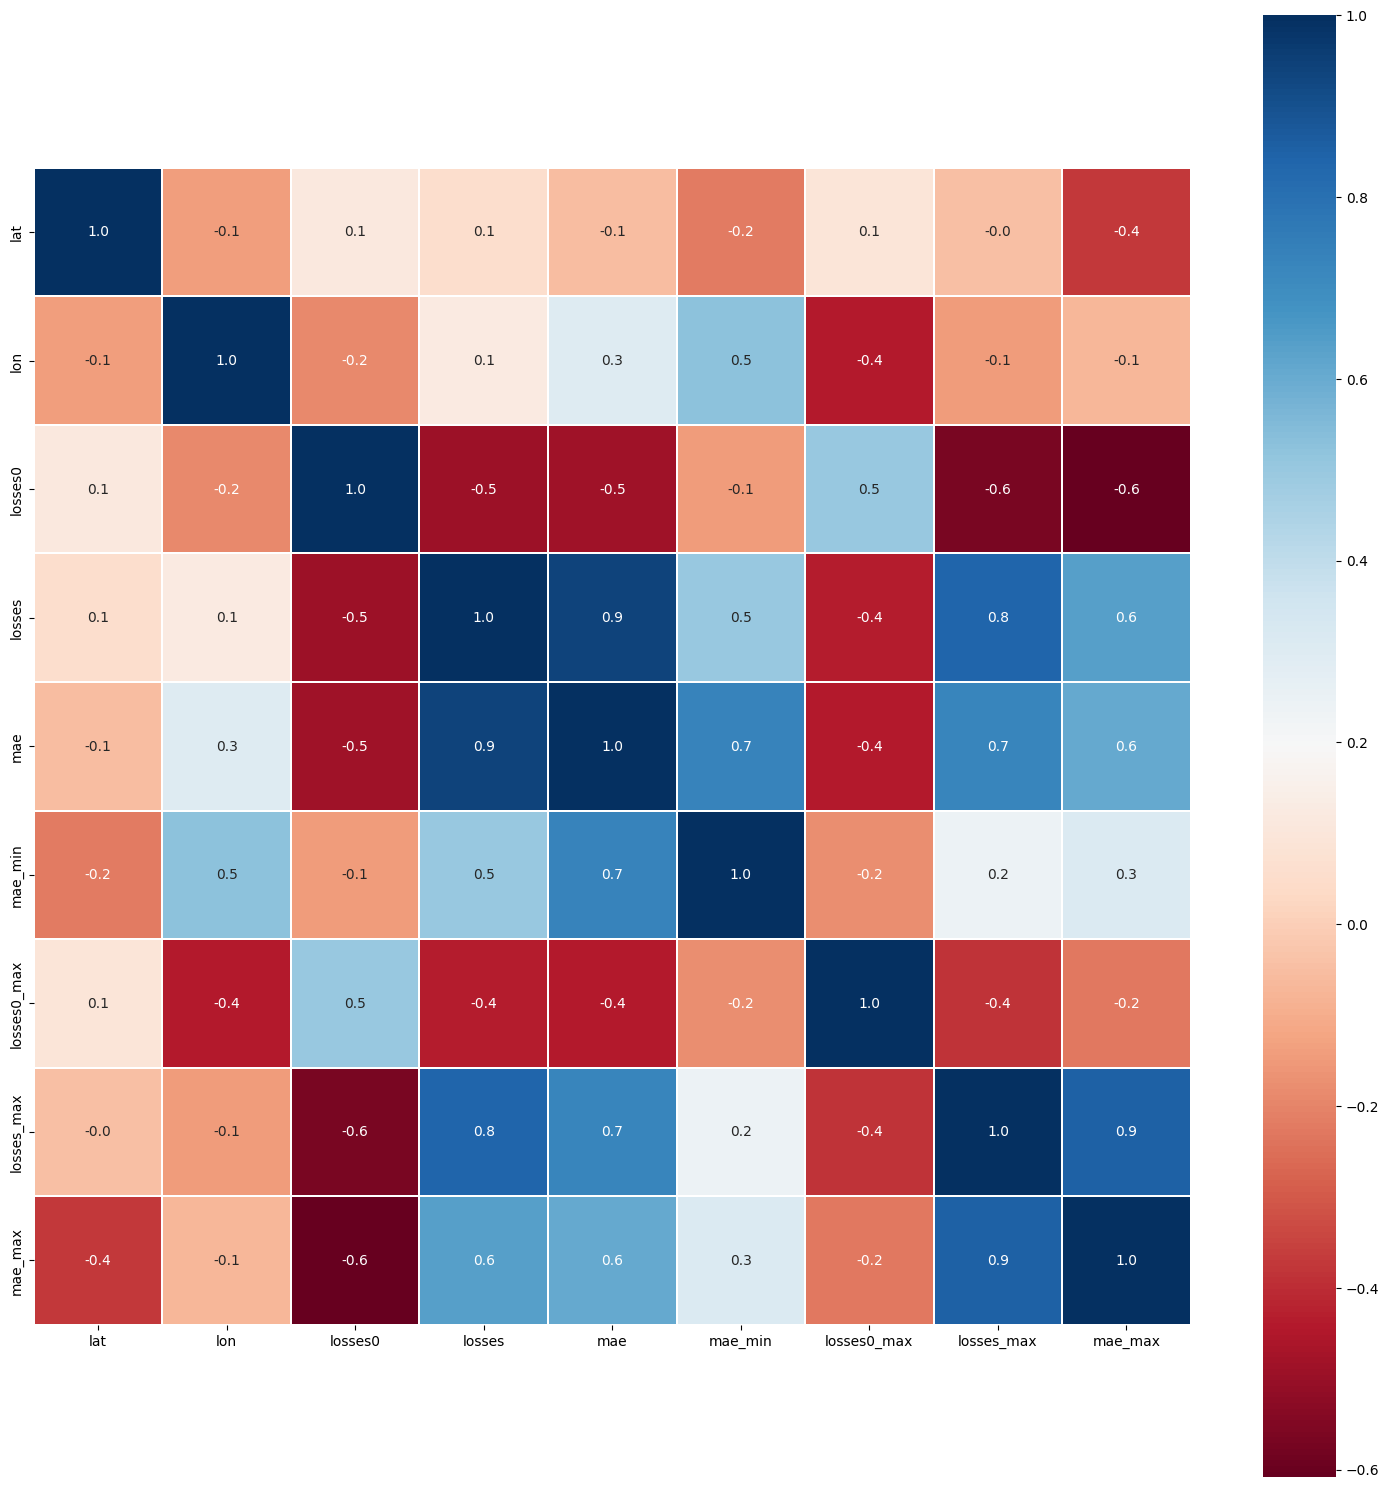

In [35]:
show_correlation(data, list(data.columns), plt, sns)

Корреляция между MAE и бизнес-метрикой 0.9

In [37]:
list(data.model.unique())

['lgb', 'lr', 'polynom', 'rf', 'xboost']

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          52 non-null     float64
 1   lon          52 non-null     float64
 2   module       52 non-null     object 
 3   model        52 non-null     object 
 4   losses0      52 non-null     float64
 5   losses       52 non-null     float64
 6   mae          52 non-null     float64
 7   mae_min      52 non-null     float64
 8   losses0_max  52 non-null     float64
 9   losses_max   52 non-null     float64
 10  mae_max      52 non-null     float64
 11  city         52 non-null     object 
dtypes: float64(9), object(3)
memory usage: 5.0+ KB


**Результаты сравнения метрики MAE:**

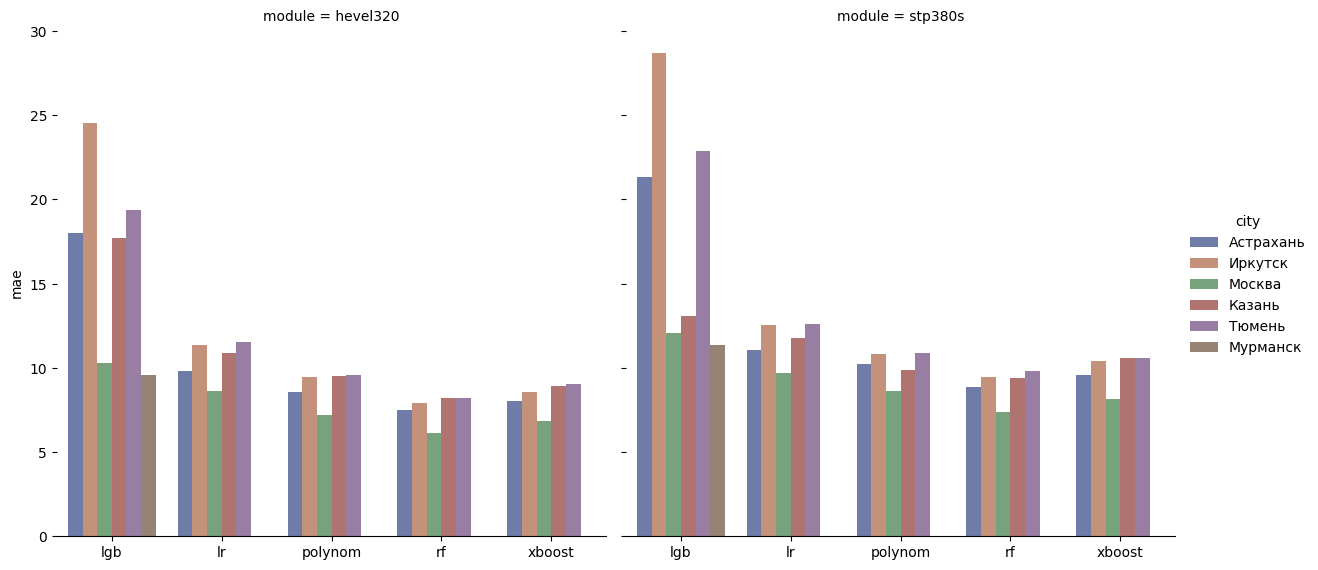

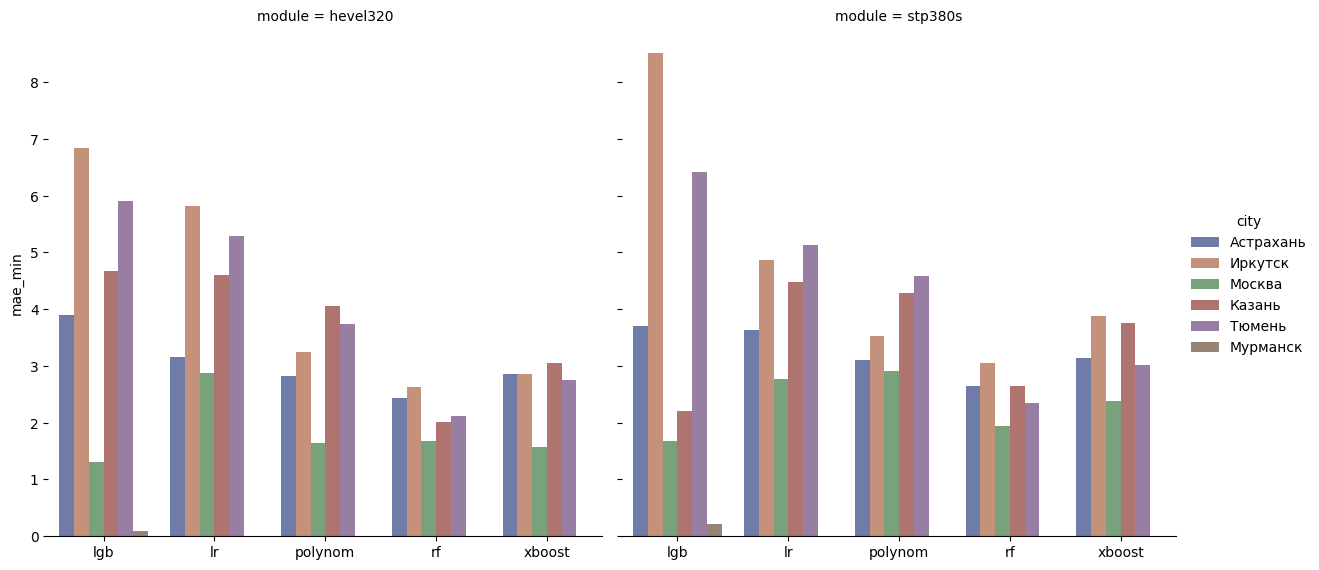

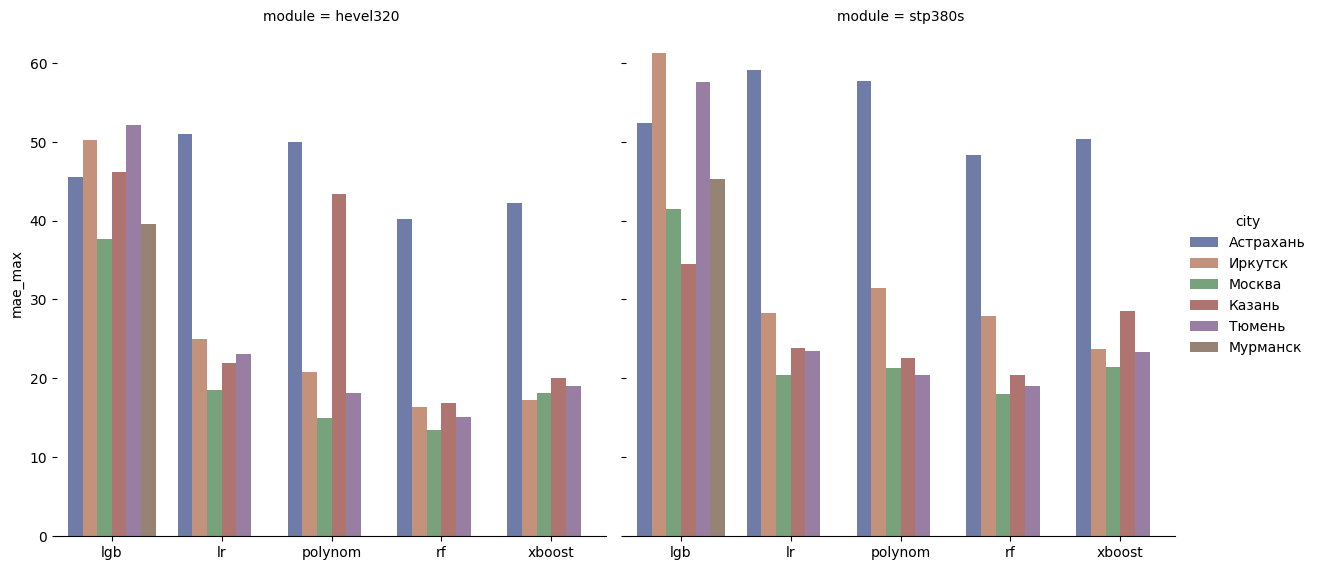

In [62]:
for y in ['mae', 'mae_min', 'mae_max']:    
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=data, kind="bar",
        x="model", y=y, hue="city",col="module",
        errorbar="sd", palette="dark", alpha=.6, height=6
    );
    g.despine(left=True);
    g.set_axis_labels("", y);
    #g.legend.set_title(data['module'])

**Результаты сравнения бизнес-метрик:**
    
    - Losses0 - потери по исходным предсказаниям,
    - Losses - потери после машинного обучения 

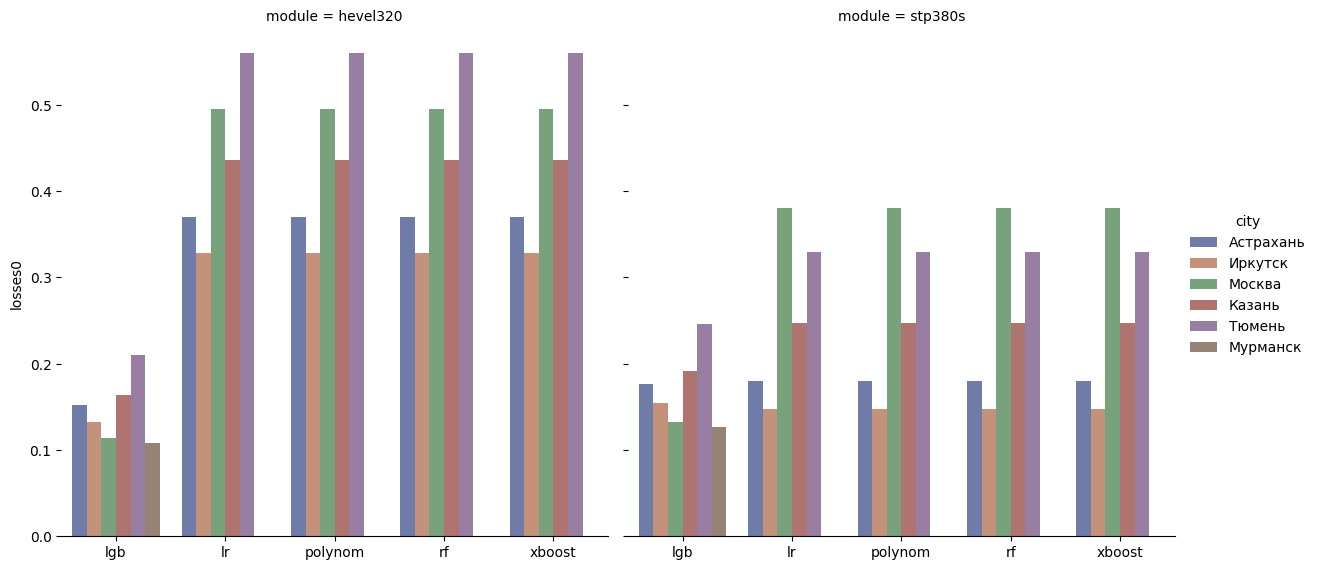

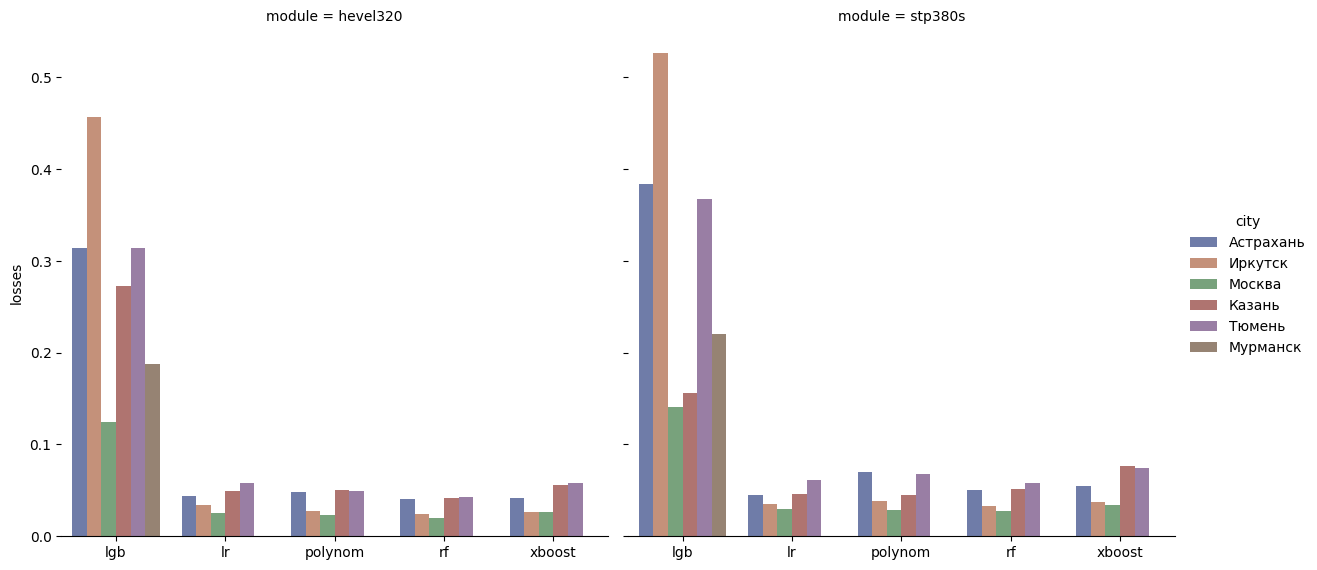

In [61]:
# Сравнение бизнес-метрик
for y in ['losses0', 'losses']:    
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=data, kind="bar",
        x="model", y=y, hue="city",col="module",
        errorbar="sd", palette="dark", alpha=.6, height=6
    );
    g.despine(left=True);
    g.set_axis_labels("", y);
    #g.legend.set_title(data['module'])
 

In [6]:
data['city'] = data['idpoint'].replace(dict_city)

In [7]:
arr_sse = []
for i in [10,12,17,18,20,23,27,38,39,40,29,30]: # дневные и 3-часовки
    arr_sse.append('sse_%s'%i)
    data['sse_%s'%i].fillna(0, inplace=True)

In [8]:
for i in [15,42,45]: # почасовки
    arr_sse.append('sse_%s'%i)
    data['sse_%s'%i].fillna(method='ffill', limit=1, inplace=True)
    data['sse_%s'%i].fillna(method='bfill', limit=1, inplace=True)
    data['sse_%s'%i].fillna(0, inplace=True)
#arr_sse  

In [9]:
data['sunshine'] = np.where(data['sse_27']>0, data['sse_23']/(2*data['sse_27']/15), 0)

- **sse_10** Monthly Averaged Diffuse Radiation Incident On A Horizontal Surface (kWh/m2/day)
- **sse_12** Monthly Averaged Direct Normal Radiation (kWh/m2/day)
- **sse_17** Monthly Averaged Insolation Normalized Clearness Index (0 to 1.0)
- **sse_18** Monthly Averaged Clear Sky Insolation Incident On A Horizontal Surface (kWh/m2/day)
- **sse_20** Monthly Averaged Clear Sky Insolation Normalized Clearness Index (0 to 1.0)
- **sse_23** Monthly Averaged Daylight Hours (hours)
- **sse_27** Monthly Averaged Sunset Hour Angle (degrees)
- **sse_38** Solar Radiation Deficits Below Expected Values Incident On A Horizontal Surface Over A Consecutive-day Period (kWh/m2)
- **sse_39** Equivalent Number Of NO-SUN Or BLACK Days (days)
- **sse_40** Available Surplus Insolation Over A Consecutive-day Period (%)
- **sse_29** Monthly Averaged Hourly Solar Angles Relative To The Horizon (degrees)
- **sse_30** Monthly Averaged Hourly Solar Azimuth Angles (degrees)
- **sse_15** Monthly Averaged Downward Longwave Radiative Flux (kWh/m2/day)
- **sse_42** Monthly Averaged Cloud Amount At Indicated GMT Times (%)
- **sse_45** Monthly Averaged Frequency Of Near-overcast Skies At Indicated GMT Times (%)

In [6]:
data['datatime'].agg(['min', 'max'])

min    2020-01-15 01:00:00
max    2022-04-01 00:00:00
Name: datatime, dtype: object

Во-первых, нам нужно преобразовать наш временной ряд в фрейм данных pandas, где каждая строка может быть идентифицирована с временным шагом и временным рядом.Набор данных, описывающий часовые данные по радиации для 6 различные географических точек. Наша задача - составить 24-часовой прогноз по выработкам для 2 устройств: hevel395 и jam72s. Существует 19368 почасовых исторических записей о погоде и выработке для каждой точки за прошлые 2 года. В дополнение к историческим данным возможно найти информацию о различных природных и климатических данных по местоположению точки: высота над уровнем моря, точка росы, загрязненность воздуха и т.д.

Набор данных уже находится в правильном формате, но в нем отсутствуют некоторые важные функции. Самое главное, нам нужно добавить временной индекс, который увеличивается на единицу для каждого временного шага. Кроме того, полезно добавить функции даты, что в данном случае означает извлечение месяца из записи даты.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116208 entries, 0 to 116207
Data columns (total 40 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lat             116208 non-null  float64
 1   lon             116208 non-null  float64
 2   month           116208 non-null  int64  
 3   hour            116208 non-null  int64  
 4   datatime        116208 non-null  object 
 5   ceres_5         116208 non-null  float64
 6   ceres_6         116208 non-null  float64
 7   ceres_albedo    116208 non-null  float64
 8   ceres_t_2m      116208 non-null  float64
 9   ceres_wind      116208 non-null  float64
 10  ghi             116208 non-null  float64
 11  albedo          116208 non-null  float64
 12  t_2m            116208 non-null  float64
 13  wind            116208 non-null  float64
 14  ceres_hevel395  116208 non-null  float64
 15  icon_hevel395   116208 non-null  float64
 16  ceres_jam72s    116208 non-null  float64
 17  icon_jam72

In [11]:
data['datatime'] = pd.to_datetime(data['datatime'])
data['lat'] = np.int16(data['lat'])
data['lon'] = np.int16(data['lon'])

In [12]:
for col in data.columns:
    if data[col].dtypes=='float64':
        data[col] = np.float32(data[col])
    if data[col].dtypes=='int64':
        data[col] = np.int16(data[col])

### Корреляция признаков

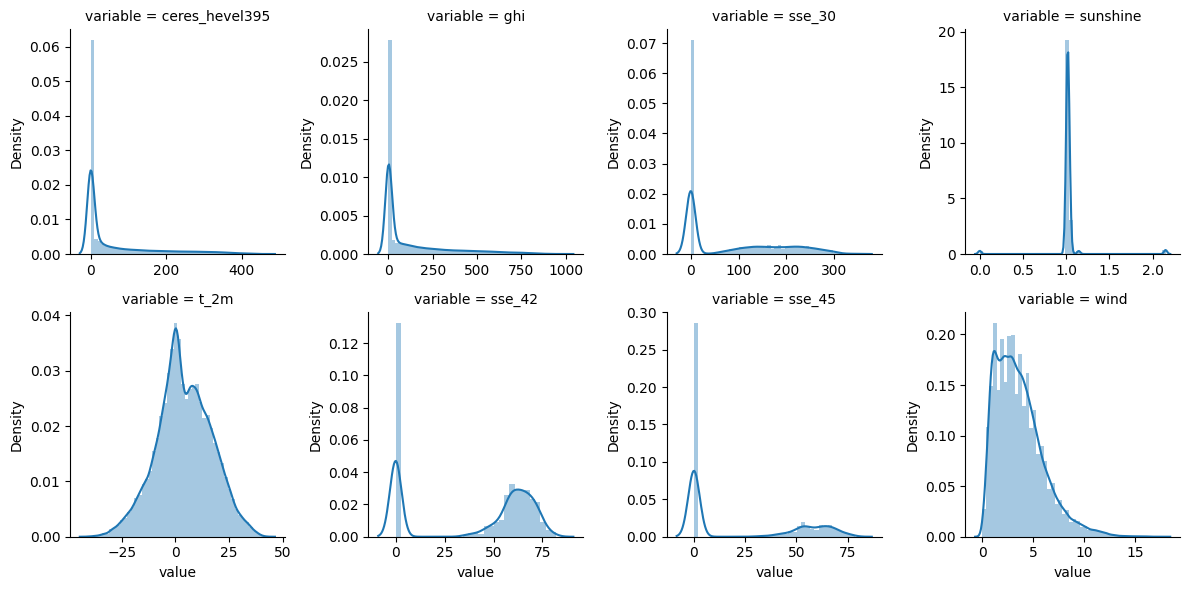

In [13]:
%%capture --no-display
nominal = ['ceres_hevel395', 'ghi', 'sse_30', 'sunshine',\
          't_2m', 'sse_42', 'sse_45', 'wind']
f = pd.melt(data, value_vars=nominal)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

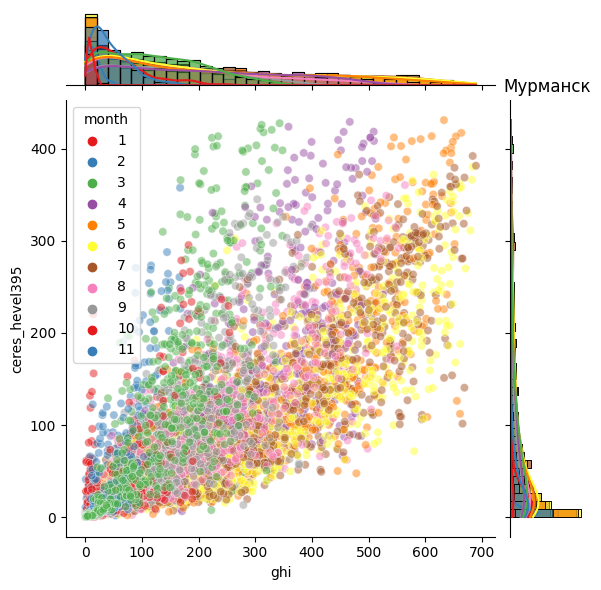

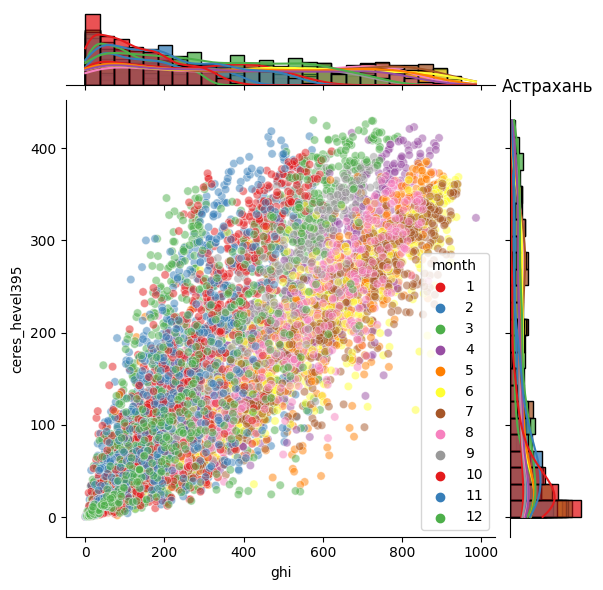

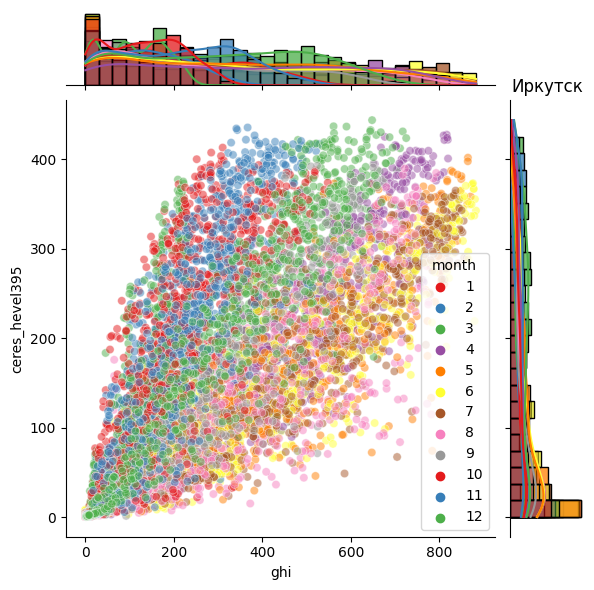

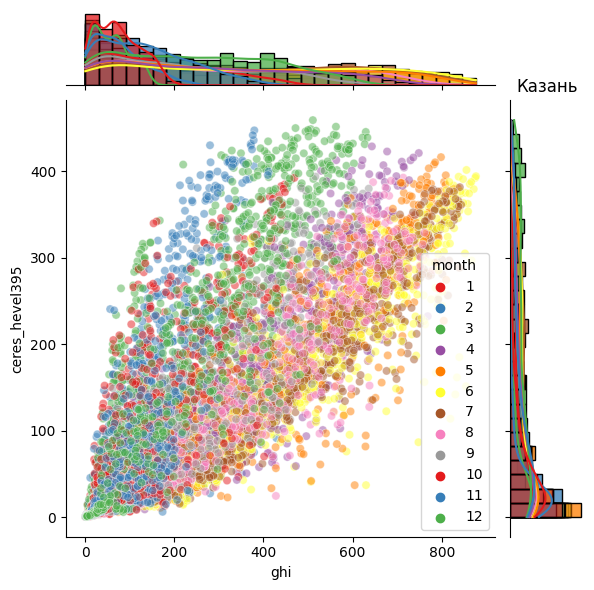

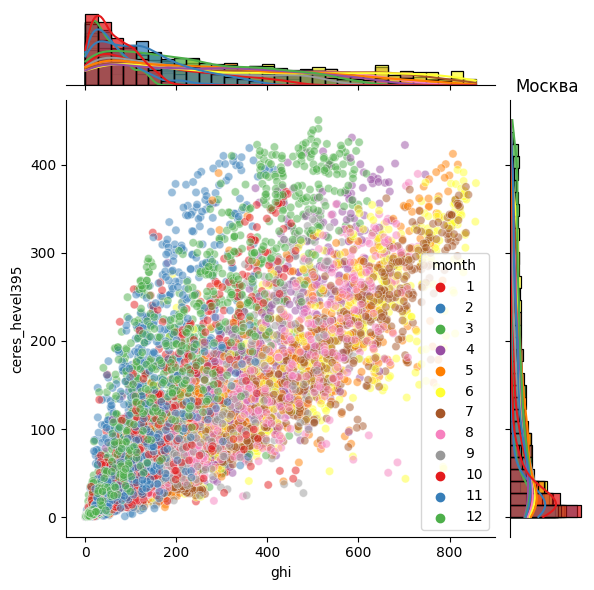

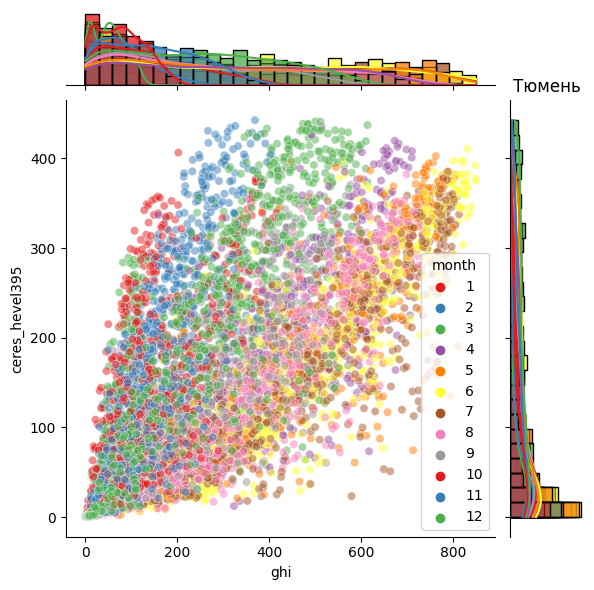

In [27]:
%%capture --no-display

module = 'ceres_hevel395'
col = 'ghi'

for idpoint in list(data['idpoint'].unique()):
    
    plot_corr(idpoint, module, col)


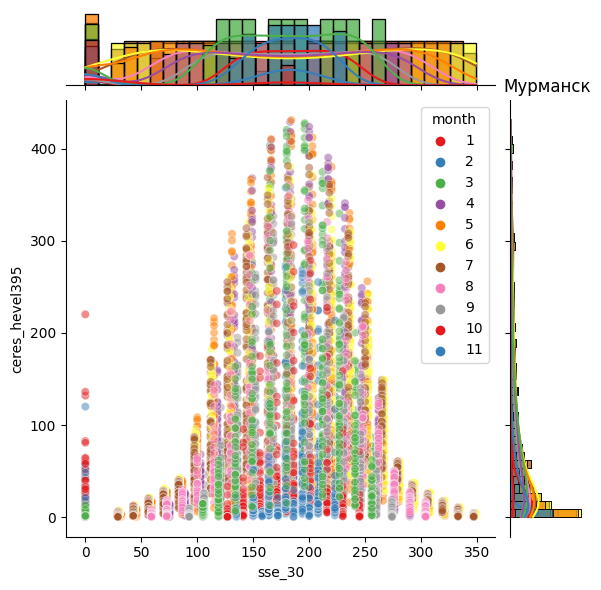

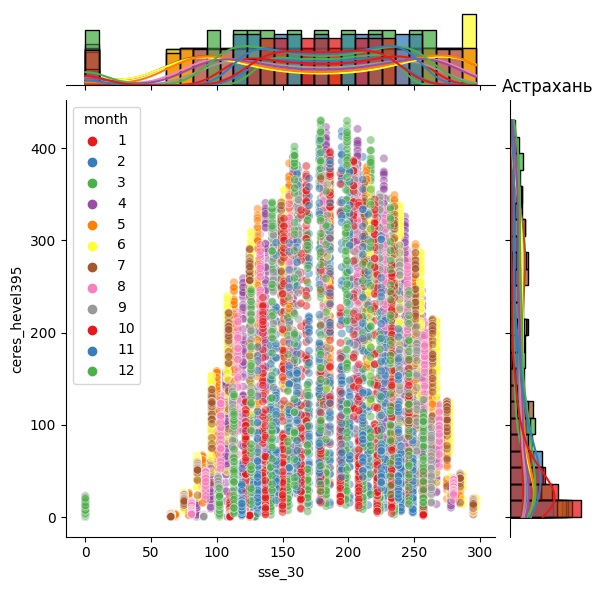

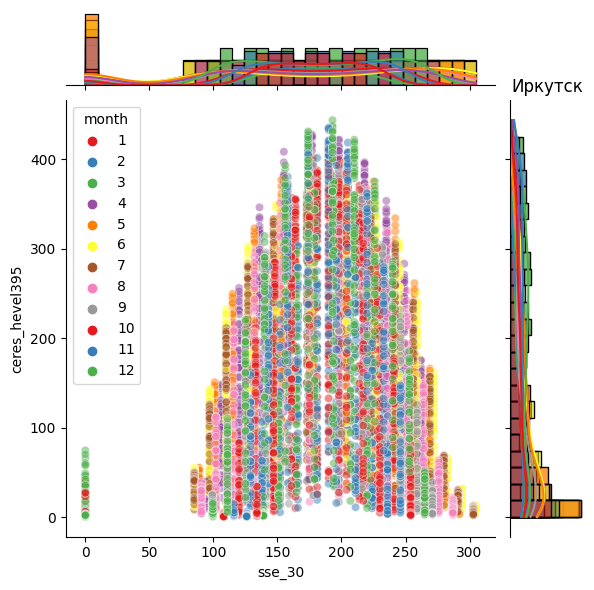

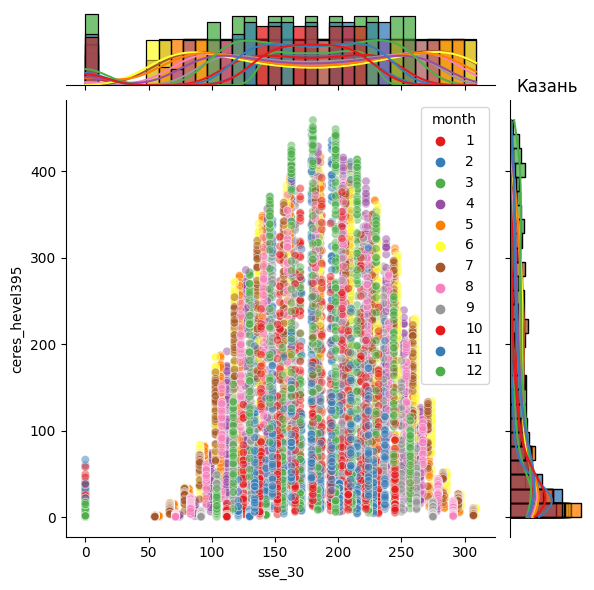

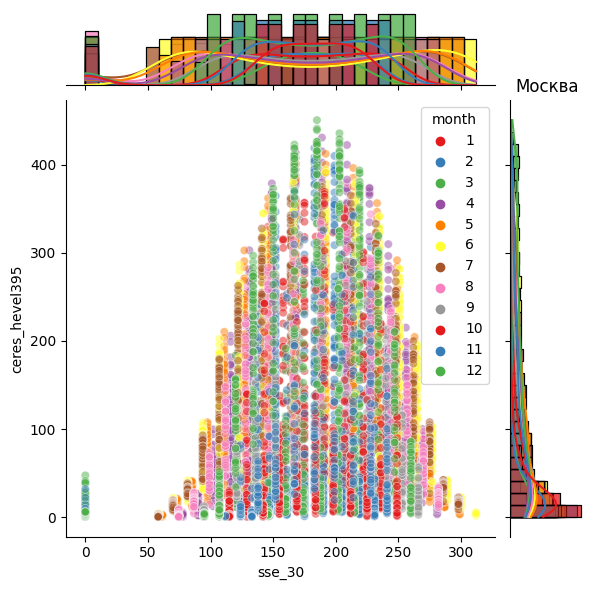

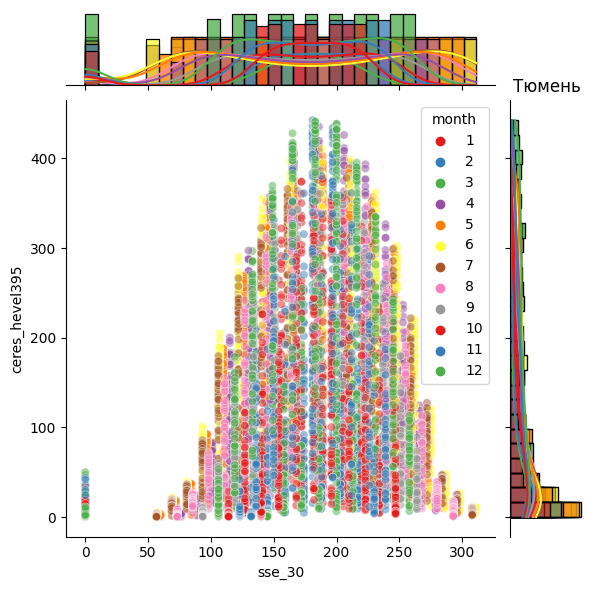

In [29]:
%%capture --no-display

module = 'ceres_hevel395'
col = 'sse_30'

for idpoint in list(data['idpoint'].unique()):
    
    plot_corr(idpoint, module, col)


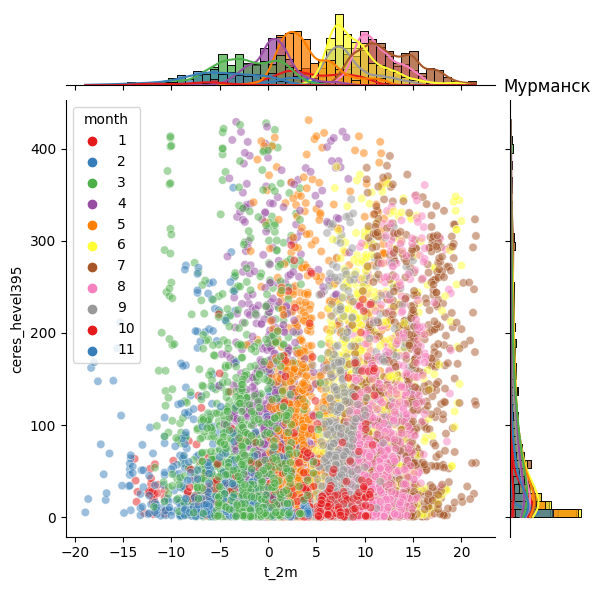

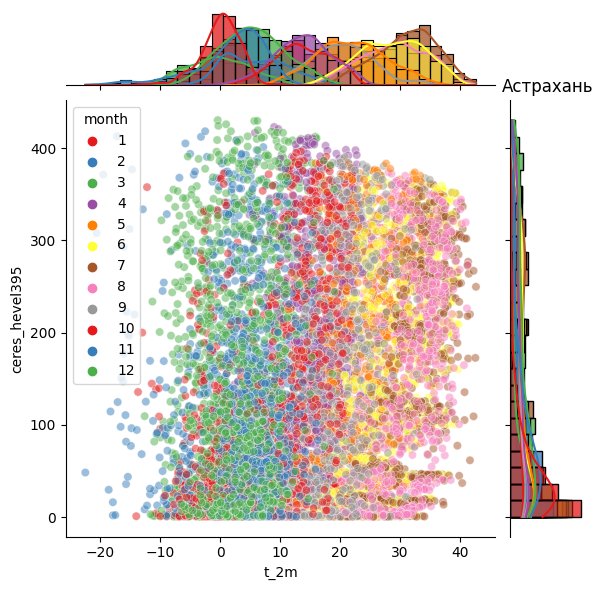

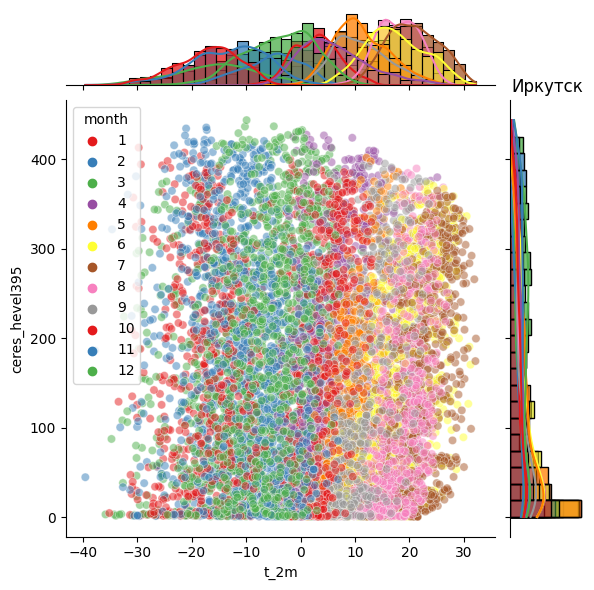

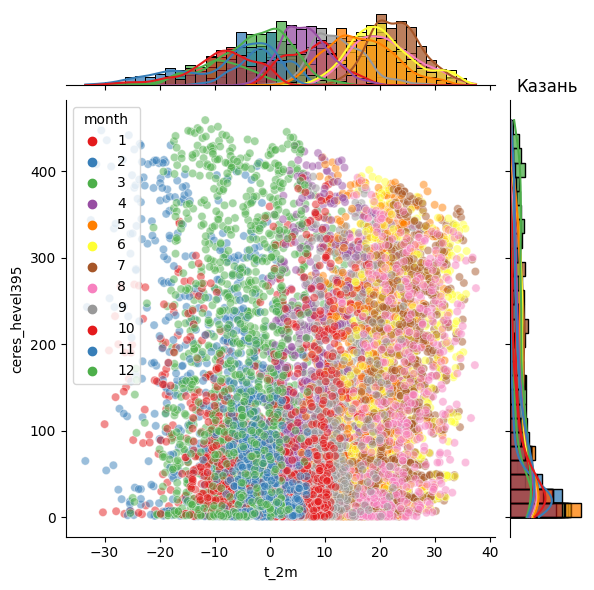

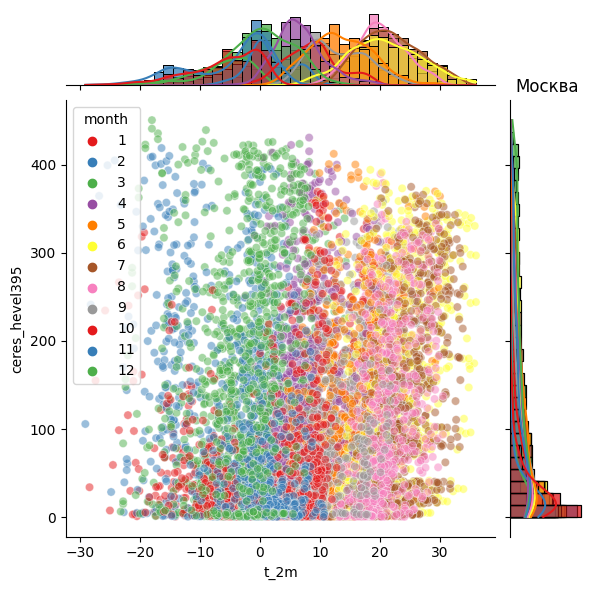

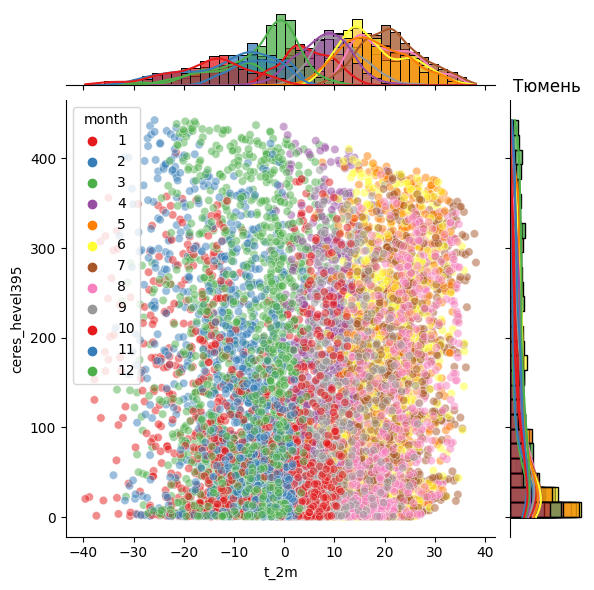

In [31]:
%%capture --no-display

module = 'ceres_hevel395'
col = 't_2m'

for idpoint in list(data['idpoint'].unique()):
    
    plot_corr(idpoint, module, col)


In [93]:
cols = list(set(data.columns) - {"ceres_jam72s", 'ceres_5', 'ceres_6', 'ceres_t_2m',\
                                 'ceres_wind', 'ceres_albedo', \
                                'icon_hevel395', 'icon_jam72s',\
                                'es', 'subject', 'district'})

C:\Users\talic\Skillfactory\ВременныеРяды\rffi_utils.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[features].corr()


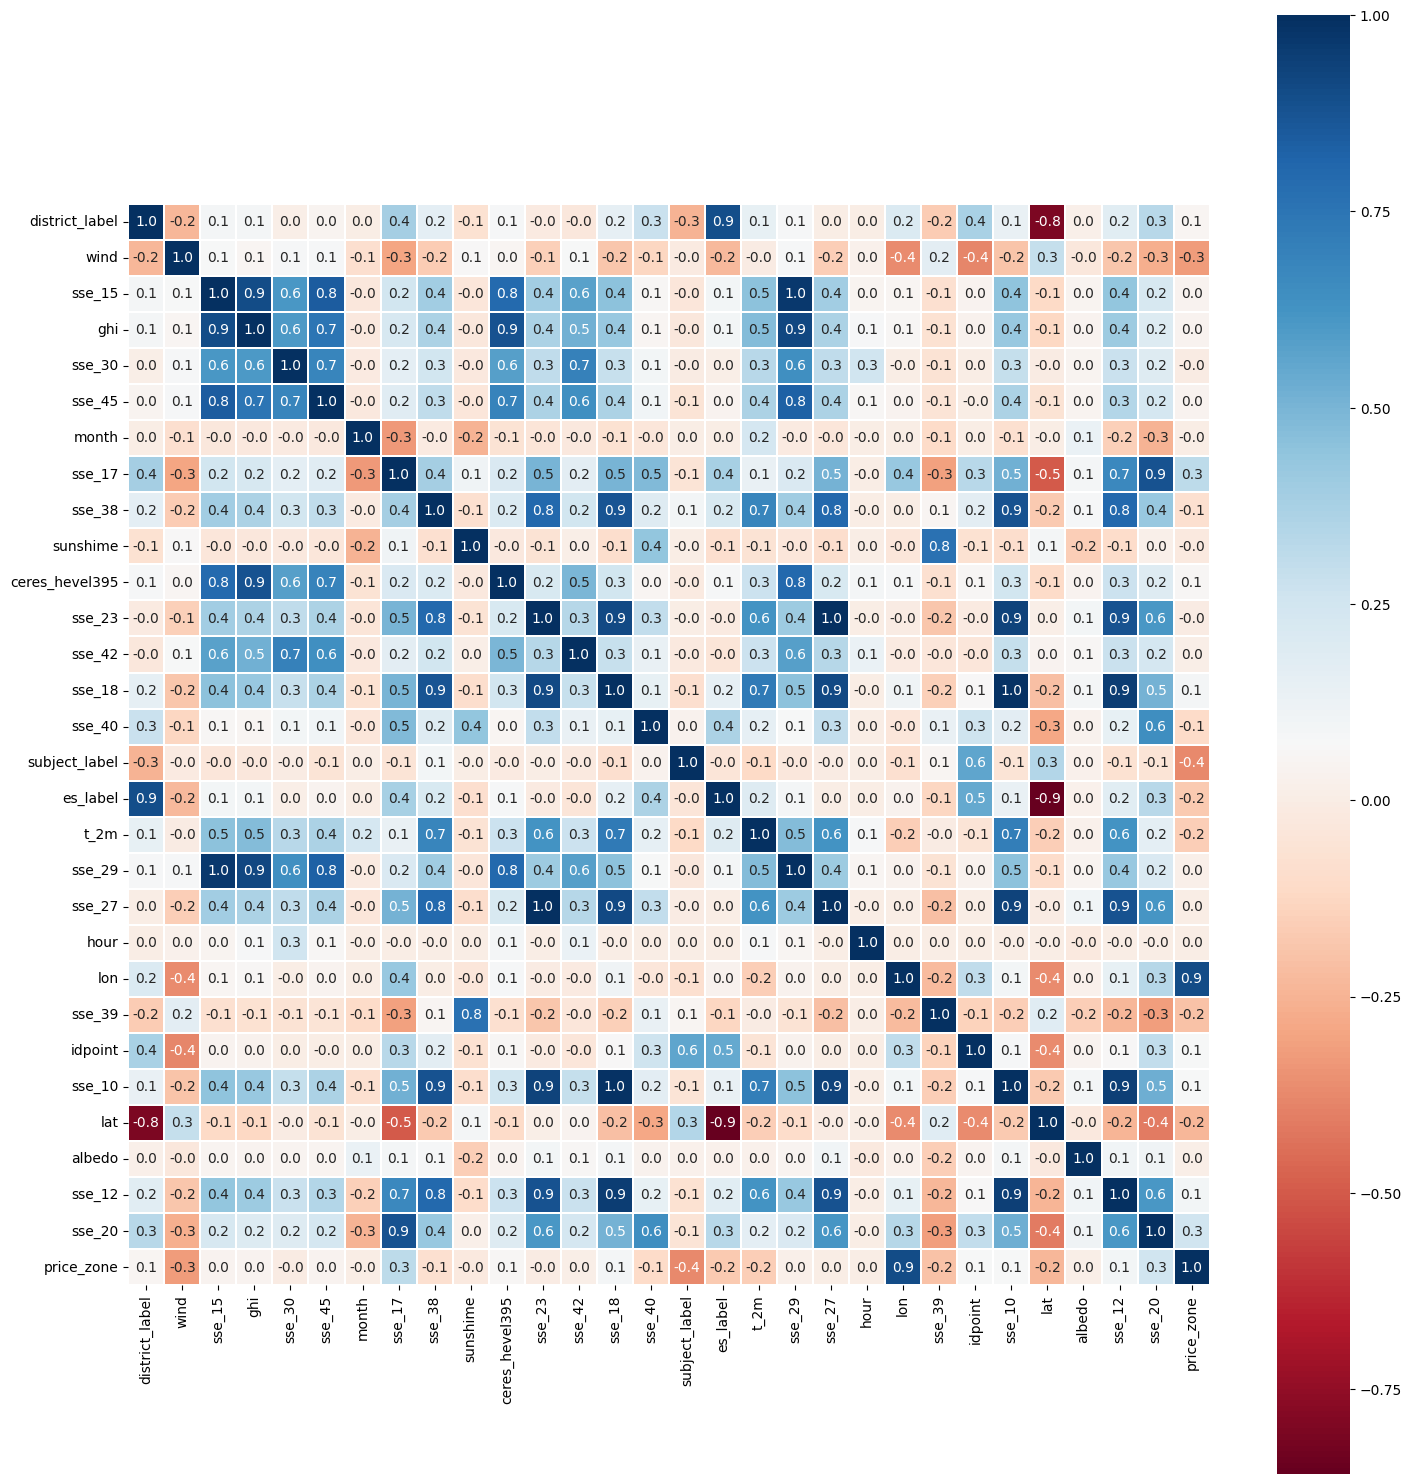

In [94]:
# Корреляция основных признаков
show_correlation(data, cols, plt, sns)

**Выводы:**
- С функцией хорошо коррелтрует только ghi (0.9) и слабо t_2m (0.3)
- зато слишком хорошо коррелируют признаки между собой:

    price_zone & lon (0.9)
    
    es_label & district_label (0.9)
    
    lat & (es_label | district_label) (-0.9)

In [10]:
# 11 вариант
cols = list(set(data.columns) - {"ceres_jam72s", 'ceres_5', 'ceres_6', 'ceres_t_2m',\
                                 'ceres_wind', 'ceres_albedo', \
                                'icon_hevel395', 'icon_jam72s',\
                                'es', 'subject', 'district','day','year',\
                                'sse_10', 'sse_12', 'sse_15','sse_23','sse_27','sse_38',\
                                'sse_17', 'sse_20', 'sse_39', 'sse_40', 'month',\
                                'subject_label', 'price_zone', 'district_label',\
                                'sse_29','hour','albedo','wind',\
                                'lat','lon','es_label', 'dow'})


C:\Users\talic\Skillfactory\ВременныеРяды\rffi_utils.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[features].corr()


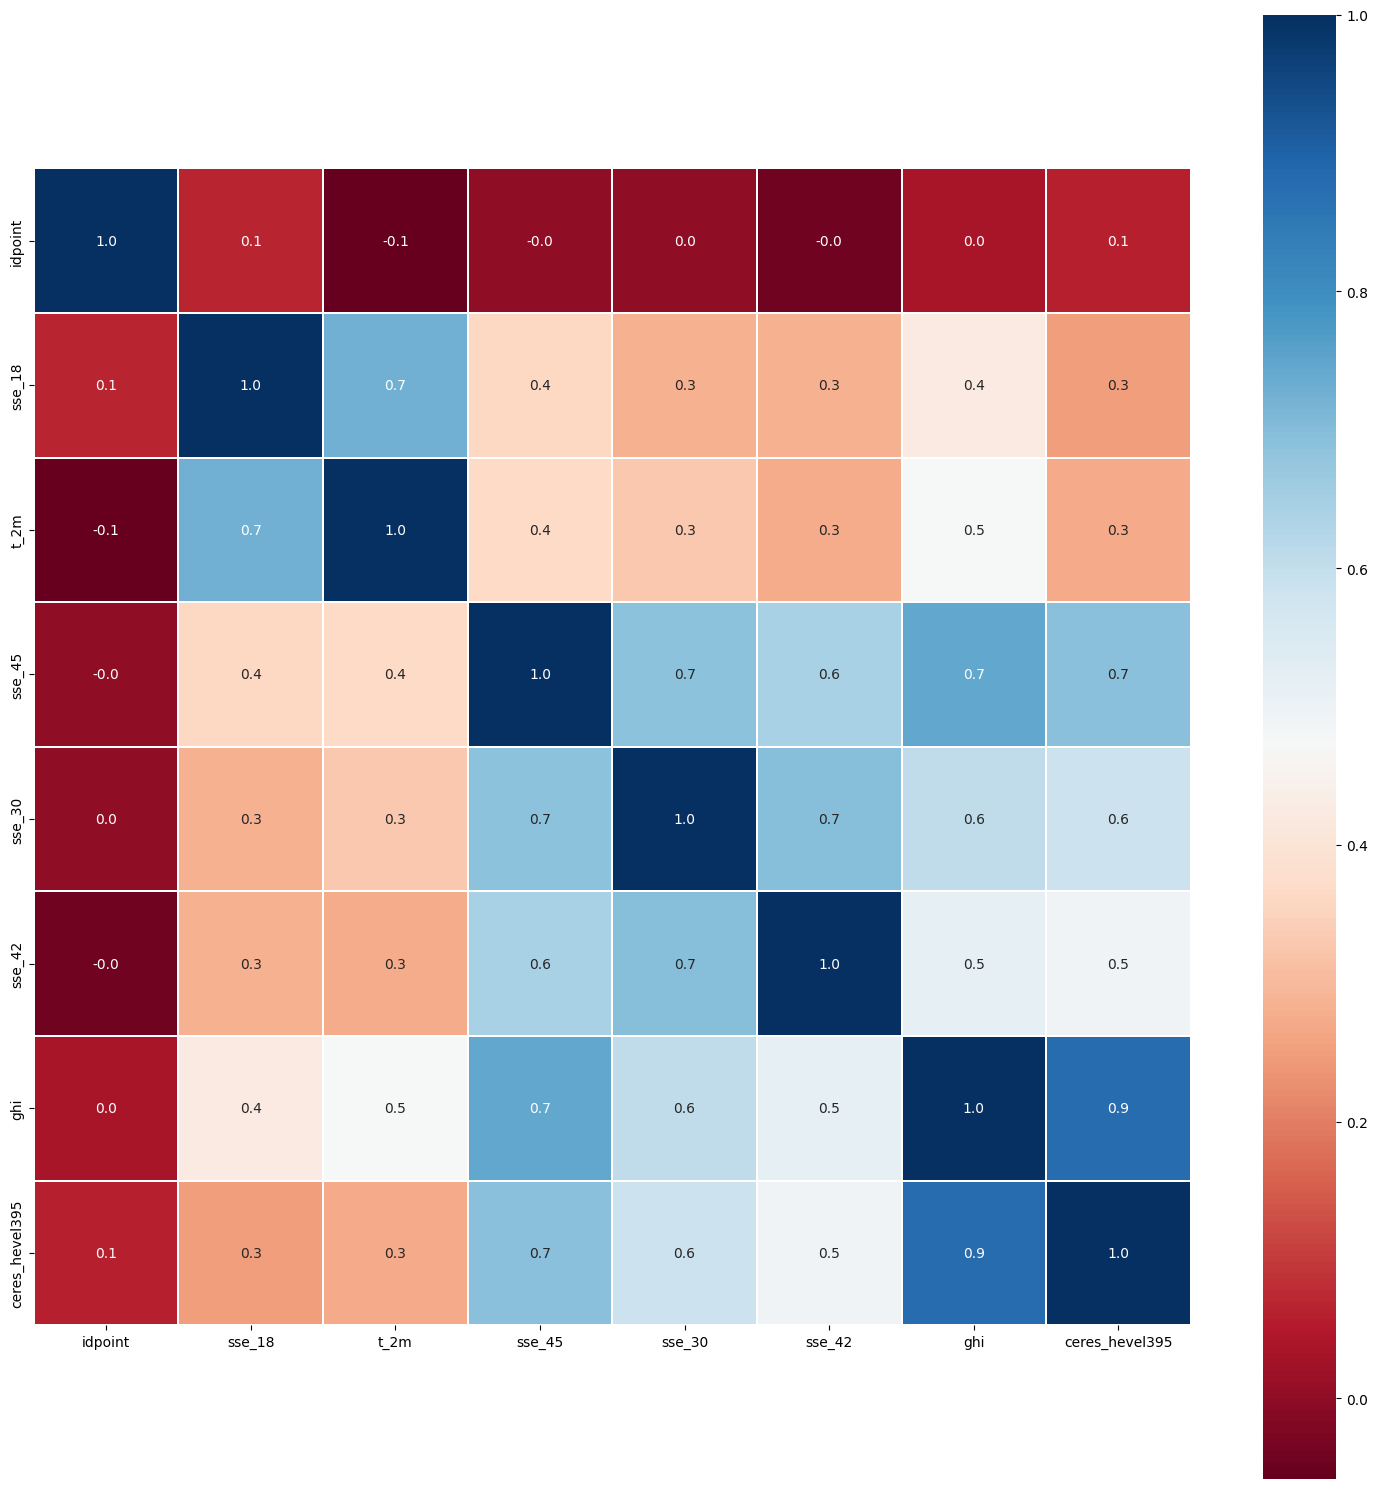

In [12]:
# Корреляция основных признаков
show_correlation(data, cols, plt, sns)

In [14]:
# Создание дополнительных временных признаков
data = create_features(data)

Text(0.5, 1.0, 'Power usage of consumers')

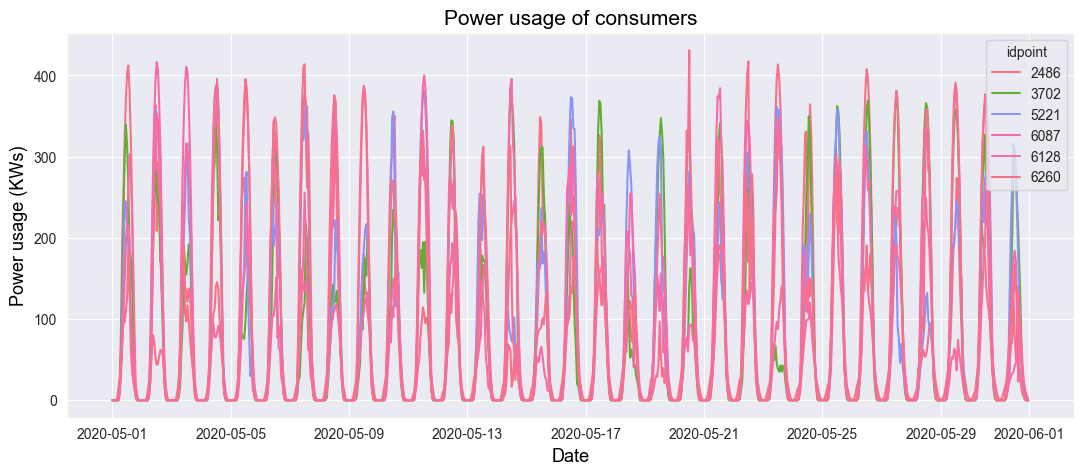

In [15]:
sns.set_style('darkgrid')
sns.color_palette("tab10")

fig, ax = plt.subplots(figsize=(13, 5))

sns.lineplot(data=data[(np.int32(data['month']) == 5)&(np.int32(data['year']) == 2020)], 
             x='datatime', 
             y='ceres_hevel395', 
             hue='idpoint', 
             legend='full',
             palette='husl').set_title('Power')

ax.set_xlabel("Date", fontdict={"color":  "black", "size": 13} )
ax.set_ylabel("Power usage (KWs)", fontdict={"color":  "black", "size": 13})
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "Power usage of consumers", fontdict={"color":  "black", "size": 15})

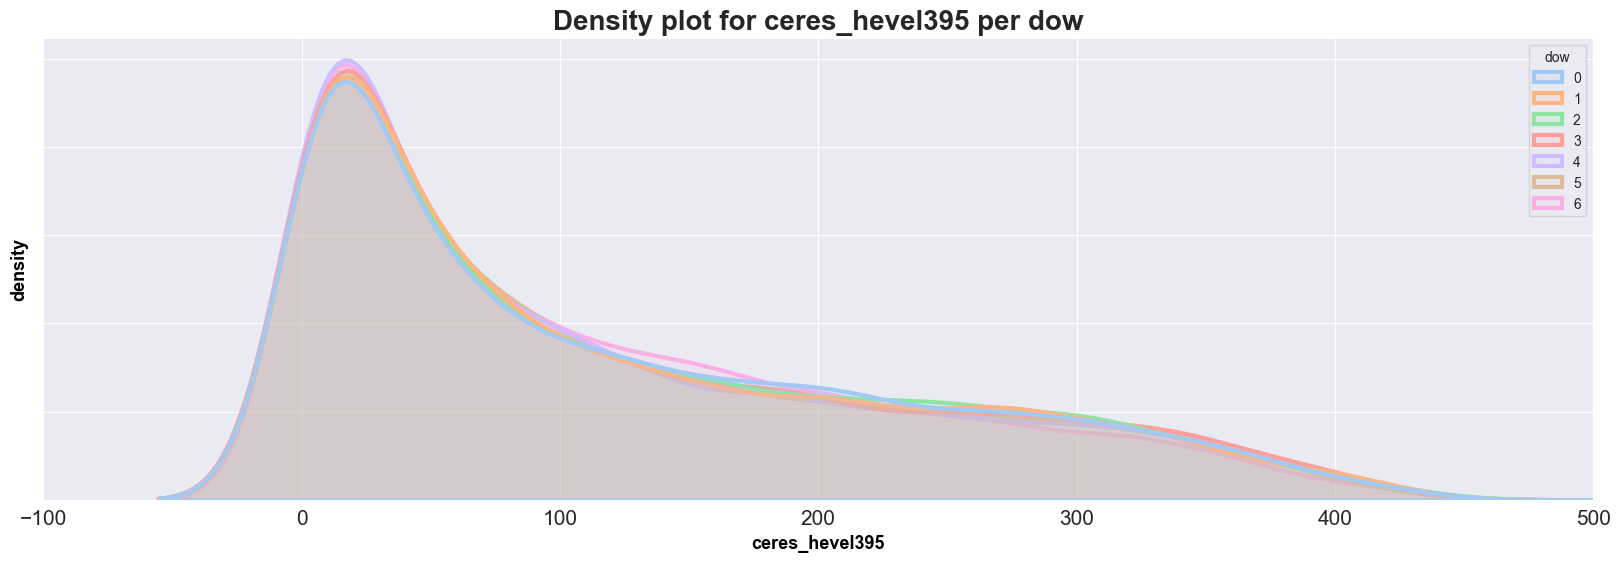

In [54]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data[data['ceres_hevel395']>0], x = 'ceres_hevel395', hue = 'dow', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-100, 500)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ceres_hevel395 per dow', fontweight = 'bold', fontsize = 20);

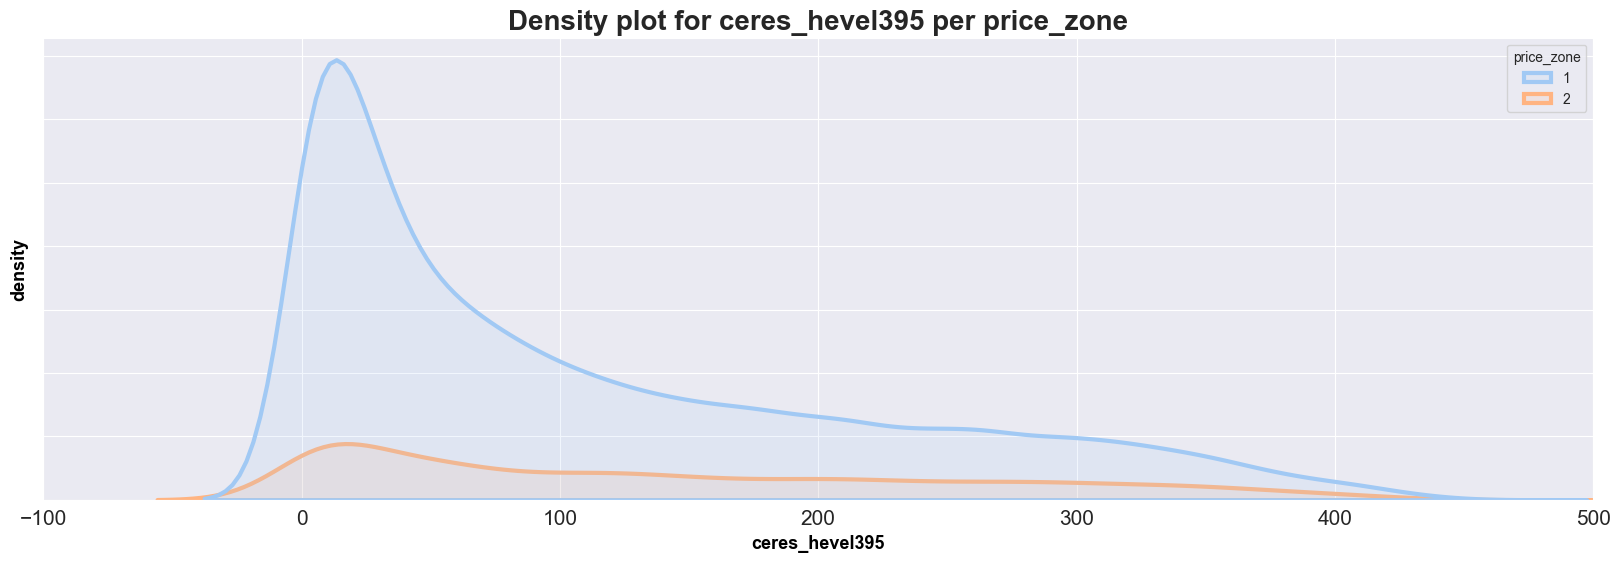

In [55]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data[data['ceres_hevel395']>0], x = 'ceres_hevel395', hue = 'price_zone', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-100, 500)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ceres_hevel395 per price_zone', fontweight = 'bold', fontsize = 20);

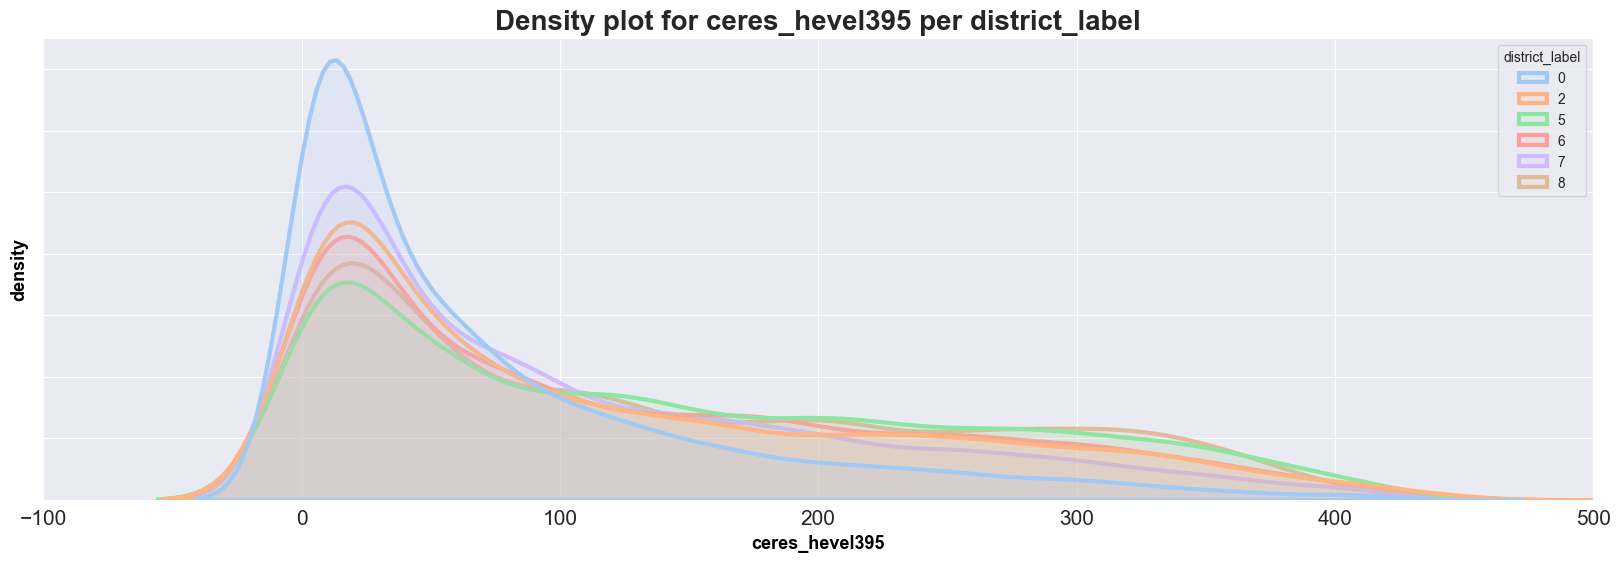

In [56]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=data[data['ceres_hevel395']>0], x = 'ceres_hevel395', hue = 'district_label', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(-100, 500)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ceres_hevel395 per district_label', fontweight = 'bold', fontsize = 20);

In [24]:
'''
index_cutoff = 6*8760*2
time_df2 = data[cols][index_cutoff:index_cutoff+6*24*7].copy()
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='datatime',y='ceres_hevel395',hue='idpoint',data=(time_df2.groupby(['datatime', 'idpoint']).ceres_hevel395.sum().rename('ceres_hevel395')
                                                       .reset_index().sort_values('datatime', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7, palette='pastel')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) 
ax.set_xlabel('datatime', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)
ax.legend(fontsize = 20, loc = 'upper left')
ax.set_title('ceres_hevel395 per point and Date', fontweight = 'bold', fontsize = 20);
'''

"\nindex_cutoff = 6*8760*2\ntime_df2 = data[cols][index_cutoff:index_cutoff+6*24*7].copy()\nfig, ax = plt.subplots(1, 1, figsize = (20, 8))\nsns.lineplot(x='datatime',y='ceres_hevel395',hue='idpoint',data=(time_df2.groupby(['datatime', 'idpoint']).ceres_hevel395.sum().rename('ceres_hevel395')\n                                                       .reset_index().sort_values('datatime', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7, palette='pastel')\n#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))\n#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) \nax.set_xlabel('datatime', color='black', fontweight='bold', fontsize=13)\nax.set_ylabel('ceres_hevel395', color='black', fontweight='bold', fontsize=13)\nax.legend(fontsize = 20, loc = 'upper left')\nax.set_title('ceres_hevel395 per point and Date', fontweight = 'bold', fontsize = 20);\n"